# Watershed Distance Transform for 3D Data
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [1]:
import os
import errno
import datetime

import numpy as np

import deepcell

Using TensorFlow backend.


### Load the Training Data

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'mousebrain.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.mousebrain.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

1730158592/1730150850 [==============================] - 28s 0us/step
X.shape: (176, 15, 256, 256, 1)
y.shape: (176, 15, 256, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [5]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

n_epoch = 10  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'whole_image'  # data normalization - `whole_image` for 3d conv
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'watershed'
distance_bins = 4  # number of distance classes
erosion_width = 0  # erode edges

# 3D Settings
frames_per_batch = 3

### First, create a foreground/background separation model

#### Instantiate the fgbg model

In [6]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_3D(
    receptive_field=receptive_field,
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    n_frames=frames_per_batch,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple([frames_per_batch] + list(X_train.shape[2:])),
    multires=False,
    last_only=False,
    norm_method='whole_image')

#### Train the fgbg model

In [7]:
from deepcell.training import train_model_conv

fgbg_model = train_model_conv(
    model=fgbg_model,
    dataset=DATA_FILE,  # full path to npz file
    expt='conv_fgbg',
    transform='fgbg',
    optimizer=optimizer,
    batch_size=batch_size,
    frames_per_batch=frames_per_batch,
    n_epoch=n_epoch,
    model_dir=MODEL_DIR,
    lr_sched=rate_scheduler(lr=0.01, decay=0.95),
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (198, 15, 256, 256, 1)
y_train shape: (198, 15, 256, 256, 1)
X_test shape: (22, 15, 256, 256, 1)
y_test shape: (22, 15, 256, 256, 1)
Output Shape: (None, 3, 256, 256, 2)
Number of Classes: 2
Training on 1 GPUs
Epoch 1/10
197/198 [============================>.] - ETA: 0s - loss: 0.9098 - model_loss: 0.2186 - model_1_loss: 0.2229 - model_2_loss: 0.2179 - model_3_loss: 0.2145 - model_acc: 0.9100 - model_1_acc: 0.9002 - model_2_acc: 0.9095 - model_3_acc: 0.9047
Epoch 00001: val_loss improved from inf to 0.83494, saving model to /data/models/2018-12-14_mousebrain_conv_fgbg.h5
198/198 [==============================] - 132s 669ms/step - loss: 0.9099 - model_loss: 0.2188 - model_1_loss: 0.2229 - model_2_loss: 0.2179 - model_3_loss: 0.2145 - model_acc: 0.9102 - model_1_acc: 0.9003 - model_2_acc: 0.9096 - model_3_acc: 0.9048 - val_loss: 0.8349 - val_model_loss: 0.1960 - val_model_1_loss: 0.2297 - val_model_2_loss: 0.1926 - val_model_3_loss: 0.1808 - val_model_acc: 0.9250 - val_m

### Next, Create a model for the watershed energy transform

#### Instantiate the distance transform model

In [8]:
from deepcell import model_zoo

watershed_model = model_zoo.bn_feature_net_skip_3D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_frames=frames_per_batch,
    n_conv_filters=32,
    n_dense_filters=128,
    multires=False,
    last_only=False,
    input_shape=tuple([frames_per_batch] + list(X_train.shape[2:])),
    norm_method='whole_image')

#### Train the model

In [9]:
from deepcell.training import train_model_conv

watershed_model = train_model_conv(
    model=watershed_model,
    dataset=DATA_FILE,  # full path to npz file
    expt='conv_watershed',
    transform=transform,
    distance_bins=distance_bins,
    erosion_width=erosion_width,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    frames_per_batch=frames_per_batch,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (198, 15, 256, 256, 1)
y_train shape: (198, 15, 256, 256, 1)
X_test shape: (22, 15, 256, 256, 1)
y_test shape: (22, 15, 256, 256, 1)
Output Shape: (None, 3, 256, 256, 4)
Number of Classes: 4
Training on 1 GPUs
Epoch 1/10
197/198 [============================>.] - ETA: 0s - loss: 3.8870 - model_5_loss: 0.9397 - model_6_loss: 0.9457 - model_7_loss: 0.9690 - model_8_loss: 0.9595 - model_5_acc: 0.8535 - model_6_acc: 0.8512 - model_7_acc: 0.8384 - model_8_acc: 0.8638
Epoch 00001: val_loss improved from inf to 3.50029, saving model to /data/models/2018-12-14_mousebrain_conv_watershed.h5
198/198 [==============================] - 174s 880ms/step - loss: 3.8831 - model_5_loss: 0.9389 - model_6_loss: 0.9446 - model_7_loss: 0.9680 - model_8_loss: 0.9585 - model_5_acc: 0.8538 - model_6_acc: 0.8515 - model_7_acc: 0.8387 - model_8_acc: 0.8640 - val_loss: 3.5003 - val_model_5_loss: 0.8762 - val_model_6_loss: 0.8645 - val_model_7_loss: 0.8364 - val_model_8_loss: 0.8499 - val_model_5_ac

### Run the model

The model was trained on only a `frames_per_batch` frames at a time.  In order to run this data on a full set of frames, a new model must be instantiated, which will load the trained weights.

#### Save weights of trained models

In [10]:
fgbg_weights_file = os.path.join(MODEL_DIR, '{}_{}_fgbg_conv.h5'.format(
    datetime.datetime.now().strftime('%Y-%m-%d'),
    os.path.splitext(os.path.basename(DATA_FILE))[0]
))
fgbg_model.save_weights(fgbg_weights_file)

watershed_weights_file = os.path.join(MODEL_DIR, '{}_{}_{}.h5'.format(
    datetime.datetime.now().strftime('%Y-%m-%d'),
    os.path.splitext(os.path.basename(DATA_FILE))[0],
    '{}_conv'.format(transform)
))
watershed_model.save_weights(watershed_weights_file)

#### Initialize the new models

In [11]:
from deepcell import model_zoo

# All training parameters should match except for the `input_shape`

run_fgbg_model = model_zoo.bn_feature_net_skip_3D(
    receptive_field=receptive_field,
    n_features=2,
    n_frames=frames_per_batch,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple(X_test.shape[1:]),
    multires=False,
    last_only=False,
    norm_method=norm_method)
run_fgbg_model.load_weights(fgbg_weights_file)

run_watershed_model = model_zoo.bn_feature_net_skip_3D(
    fgbg_model=run_fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_frames=frames_per_batch,
    n_conv_filters=32,
    n_dense_filters=128,
    multires=False,
    last_only=False,
    input_shape=tuple(X_test.shape[1:]),
    norm_method=norm_method)
run_watershed_model.load_weights(watershed_weights_file)

In [12]:
# too many batches at once causes OOM
X_test, y_test = X_test[:4], y_test[:4]
print(X_test.shape)

(4, 15, 256, 256, 1)


#### Make predictions on test data

In [13]:
test_images = run_watershed_model.predict(X_test)[-1]
test_images_fgbg = run_fgbg_model.predict(X_test)[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (4, 15, 256, 256, 4)
segmentation mask shape: (4, 15, 256, 256, 2)


#### Watershed post-processing

In [14]:
argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

watershed argmax shape: (4, 15, 256, 256, 1)


In [15]:
# threshold the foreground/background
# and remove back ground from watershed transform
threshold = 0.5

fg_thresh = test_images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

argmax_images_post_fgbg = argmax_images * fg_thresh

In [16]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(
        test_images[i, ..., -1],
        min_distance=10,
        threshold_abs=0.05,
        indices=False,
        labels=image,
        exclude_border=False)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=-1)

### Plot the results

Image: 2
Frame: 7


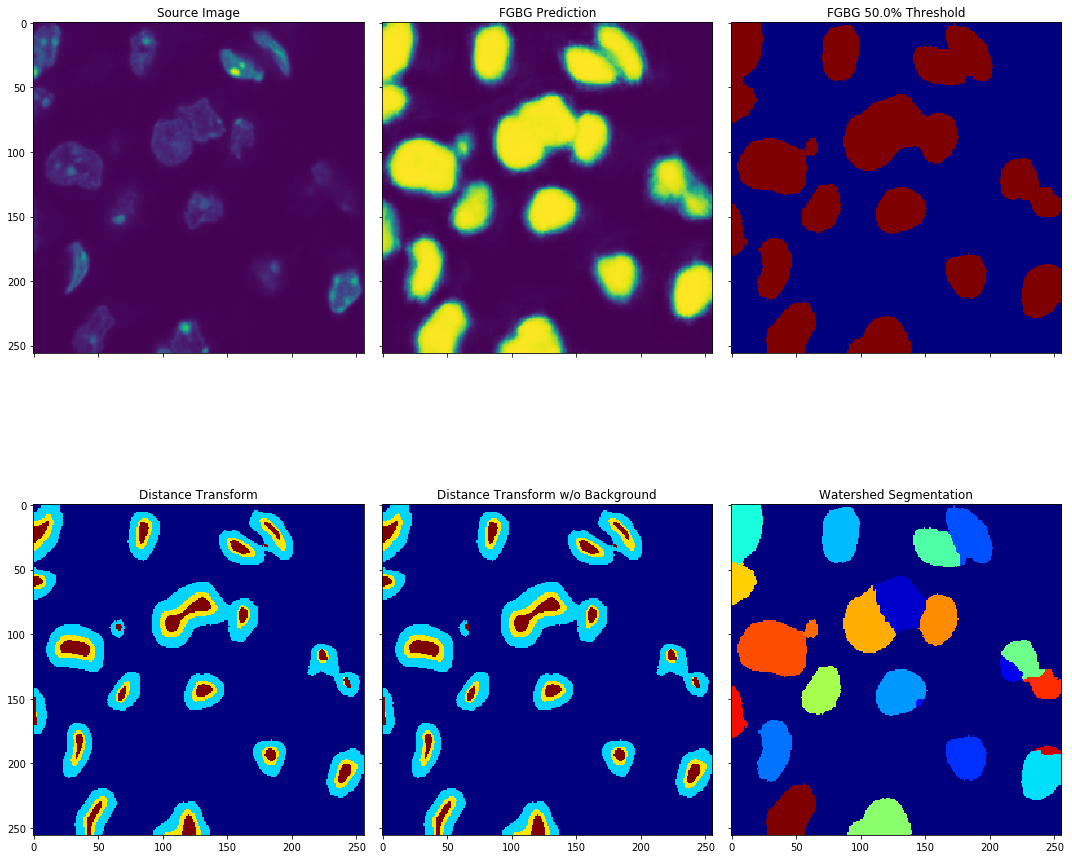

In [20]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

index = 2#np.random.randint(low=0, high=watershed_images.shape[0])
frame = 7#np.random.randint(low=0, high=watershed_images.shape[1])

print('Image:', index)
print('Frame:', frame)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('FGBG Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG {}% Threshold'.format(int(threshold * 100)))

ax[3].imshow(argmax_images[index, frame, ..., 0], cmap='jet')
ax[3].set_title('Distance Transform')

ax[4].imshow(argmax_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform w/o Background')

ax[5].imshow(watershed_images[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()

In [21]:
# Can also export as a video
# But this does not render well on GitHub
from IPython.display import HTML
from deepcell.utils.plot_utils import get_js_video

HTML(get_js_video(watershed_images[..., [-1]], batch=index))